# Messing with Magnetic Fields & Particle Propagation

Simple integration to plot trajectories of charged particles exposed to a magnetic or electric field!

-------
-------
-------

## Charged particles in a constant B field (cartesian)

From electrodynamics, we know that the motion (Lorentz force) experienced by a particle goes as:
$$
\begin{align}
 \frac{\vec{F}}{m} & = \vec{a} = \frac{d\vec{v}}{dt},\\
 \frac{d\vec{v}}{dt} & = \frac{q}{m}(\vec{v}\times\vec{B})
   \end{align} $$
For simplicity, we will begin with a magnetic field of the form
$$\vec{B} = B\vec{e_{x}}$$
eventually making our way towards a magnetic dipole as an approximation for the Earth's magnetosphere.

In [1]:
import numpy as np
from scipy.integrate import ode
# Could potentially use any canned ode solver (or make your own)!

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3-D plots are a fantastic tool to visualize these particle trajectories.

# Useful for visual resolution.
%matplotlib notebook
%config InlineBackend.figure_format='retina'

In [2]:
"""Define the lorentz force equation for use in ODE solver.
   R represents our state vector (with associated cartesian positions
   and velocities), returns dR/dt."""
def lorentz(t,R,q,m,B):
    x,y,z    = R[0], R[1], R[2]
    vx,vy,vz = R[3], R[4], R[5]
    
    param = q/m*B
    return np.array([vx,vy,vz, 0,param*vz,-param*vy]) #  cross product of (v x B).

In [3]:
# Let's initialize scipy's integration technique!
solver = ode(lorentz).set_integrator('dopri5') # Implements an explicit runge-kutta order (4).

Let's feed our solver some initial conditions for time, position, and velocity:

In [4]:
t0 = 0
x0 = np.array([0, 0, 0])
v0 = np.array([1, 1, 0])
initial_conditions = np.concatenate((x0, v0))

In [5]:
solver.set_initial_value(initial_conditions, t0).set_f_params(1.0, 1.0, 1.0) # set q, m, B strength.

positions = []
tf = 50
dt = 0.05

# Iterate through scipy's ode solver --> tf.
while solver.successful() and solver.t < tf:
    solver.integrate(solver.t+dt)
    positions.append(solver.y[:3]) # keep only position!

positions = np.array(positions)

Now that we've solved for the **positions** with our intial setup, we can plot a 3-D representation of the charged particle's cartesian coordinates in relation to the $B\vec{e_{x}}$ field!

<IPython.core.display.Javascript object>


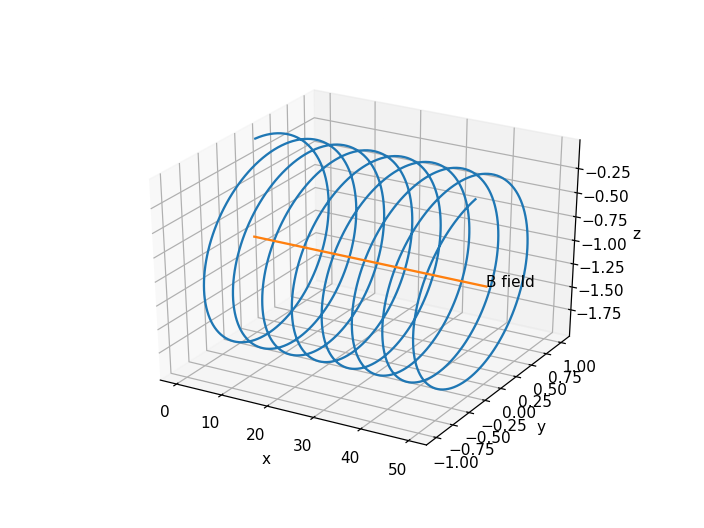

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.
ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2]) # solution x, y, z

B1 = np.array([x0[0], x0[1], -1])
B2 = np.array([50, 0, 0])
B_axis = np.vstack((B1, B1 + B2))
ax.plot3D(B_axis[:, 0], 
          B_axis[:, 1],
          B_axis[:, 2])
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
ax.text3D((B1 + B2)[0], (B1 + B2)[1], (B1 + B2)[2], 'B field');

### Awesome, this works quite well! 
**Now we need to generalize to spherical coordinates for ease of dipole creation.**

# Let's try to make spherical coordinates!

Spherical to cartesian:
$$x=r\sin \theta \cos \phi   \\
  y=r\sin \theta \sin \phi   \\
  z=r\cos \theta$$
  
Cartesian to spherical:
$$r=\sqrt{x^2+y^2+z^2}       \\
  \theta = \arctan{(\frac{\sqrt{x^2+y^2}}{z})}\\
  \phi = \arctan{(\frac{y}{x})}$$
  
Spherical unit vectors from cartesian:
$$\hat{r}=\sin{\theta}(\cos{\phi}\hat{x}+\sin{\phi}\hat{y})+\cos{\theta}\hat{z}   \\
\hat{\theta}=\cos{\theta}(\cos{\phi}\hat{x}+\sin{\theta}\hat{z})-\sin{\theta}\hat{z}   \\
\hat{\phi}=-\sin{\phi}\hat{x}+\cos{\phi}\hat{y}$$

Given a set of $[x,y,z]$ coordinates, we can easily calculate their $[r,\theta,\phi]$ projections!

Subsequently, we can interact the particles in our spherical frame, with the simplest magnetic dipole equation in terms of spherical coordinates as well.

With, $$\textbf{m}=m\hat{z}$$ 
$$ B_{\textrm{dipole}}=\frac{2m\cos{\theta}}{r^3}\hat{r}+\frac{m\sin{\theta}}{r^3}\hat{\theta}$$

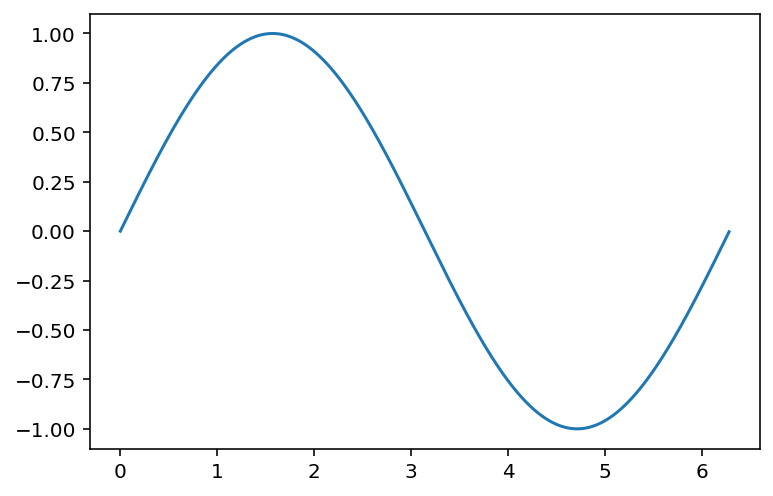

In [7]:
# Here, m is the magnitude of the dipole moment.
theta = np.arange(0,2*np.pi,0.01) 
m     = 1
r     = 1

# This only takes theta, not radius (not ideal).
def magDip(theta):
    B = np.zeros((2,len(theta)))
    for i,t in enumerate(theta):
        Br   = (2*m*np.cos(theta))/r**3
        B0   = (m*np.sin(theta))  /r**3
        B[0] = Br # radial contribution
        B[1] = B0 # polar angle cont.
    return B

%matplotlib inline
%matplotlib inline
plt.plot(theta,magDip(theta)[1,:])

We've made the magnetic dipole contributions, let's allow them to interact with a particle:

$$ \vec{v}\times B_{\textrm{dipole}} $$ \
$$ =\vec{v} \times \left(\frac{2m\cos{\theta}}{r^3}\hat{r}+\frac{m\sin{\theta}}{r^3}\hat{\theta}\right). $$\
$$ \vec{v}_r \times B_{\textrm{dipole}} = v_r \frac{m \sin{\theta}}{r^3} \hat{\phi}$$\
$$ \vec{v}_{\theta} \times B_{\textrm{dipole}} = -v_{\theta} \frac{2m \cos{\theta}}{r^3} \hat{\phi}$$\
$$ \vec{v}_{\phi} \times B_{\textrm{dipole}} = v_{\phi} \frac{2m \cos{\theta}}{r^3} \hat{\theta}-v_{\phi} \frac{m \sin{\theta}}{r^3} \hat{r}$$

In [8]:
def magDip(r,theta,m):
    B = np.zeros((2,1))
    Br   = (2*m*np.cos(theta))/r**3
    B0   = (m*np.sin(theta))  /r**3
    B[0] = Br # radial contribution
    B[1] = B0 # polar angle cont.
    return B

In [9]:
def param(r,q,m,theta,i): # i=0=r, i=1=theta
    p = q/m*magDip(r,theta,m)[i]
    return p

In [10]:
"""Define the lorentz force equation for use in ODE solver.
   R represents our state vector (with associated cartesian positions
   and velocities), returns dR/dt."""
def lorentz(t,R,q,m):
    r, theta, phi    = R[0], R[1], R[2]
    vr, vtheta, vphi = R[3], R[4], R[5]

    return np.array([vr,vtheta,vphi, 
                     param(r,q,m,theta,1)*vr,
                     -vtheta*param(r,q,m,theta,0),
                     vphi*param(r,q,m,theta,0)-vphi*param(r,q,m,theta,1)]) #  cross product of (v spher. x B spher.).

In [11]:
# Let's initialize scipy's integration technique!
solver = ode(lorentz).set_integrator('dopri5') # Implements an explicit runge-kutta order (4).

In [14]:
t0 = 0
R0 = np.array([10, 0, 0])
v0 = np.array([-0.1, 0.2, 0.2])
initial_conditions = np.concatenate((R0, v0))

In [15]:
solver.set_initial_value(initial_conditions, t0).set_f_params(1.0, 1.0) # set q, m, B strength.

positions = []
tf = 50
dt = 0.05

# vectorize!
# time array. No need to continue calling.
# 

# Iterate through scipy's ode solver --> tf.
while solver.successful() and solver.t < tf:
    solver.integrate(solver.t+dt)
    positions.append(solver.y[:6]) # keep everything (position and velocity?)!
    
times = np.arange(0,tf,dt)
solver.integrate(solver.t)

positions = np.array(positions)

<IPython.core.display.Javascript object>


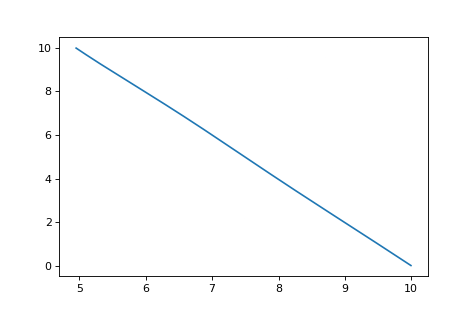

In [17]:
%matplotlib notebook
%matplotlib notebook

fig,ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1])

<IPython.core.display.Javascript object>


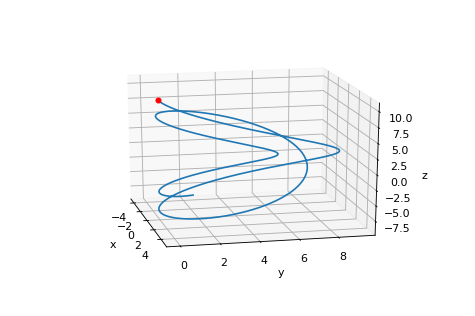

In [18]:
X = positions[:, 0] * np.sin(positions[:, 2]) * np.cos(positions[:, 1])
Y = positions[:, 0] * np.sin(positions[:, 2]) * np.sin(positions[:, 1])
Z = positions[:, 0] * np.cos(positions[:, 2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.
ax.plot3D(X, Y, Z) # solution x, y, z
ax.scatter3D(X[0],Y[0],Z[0],color='red')

B1 = np.array([x0[0], x0[1], -1])
B2 = np.array([50, 0, 0])
B_axis = np.vstack((B1, B1 + B2))
# ax.plot3D(X, 
#           Y,
#           Z)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
ax.text3D((B1 + B2)[0], (B1 + B2)[1], (B1 + B2)[2], 'B field');

# Imports for animation:

In [17]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [18]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

Test call to animate (takes a while to render)

In [19]:
# FRAMES = 500
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# def init():
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
    
# # animation function.  This is called sequentially
# def animate(i):
#     current_index = int(positions.shape[0] / FRAMES * i)
#     ax.cla()
#     ax.plot3D(X[:current_index], 
#               Y[:current_index], 
#               Z[:current_index])
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
# # call the animator.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=FRAMES, interval=500)

# # call our new function to display the animation
# display_animation(anim)

Absolutely wild looking! This may be error in the code, but it sure looks cool!

## Notice that a perfect dipole approximation will not suffice!
#### We must account for the finite radius of the Earth, and properly visualize the field lines.

$$ B(r) = \frac{\mu_0}{4\pi r^3}[3\hat{r}(\hat{r}\cdot m)-m] $$

Thus, we can, again, decompose this into spherical coordinates (but with an Earth scale radius).

$$ B_r = -2B_0 \left( \frac{R_E}{r} \right)^3 \cos{\theta} $$

$$ B_{\theta}=-B_0\left( \frac{R_E}{r} \right)^3 \sin{\theta} $$

$$ B_{\phi}=0 $$

<IPython.core.display.Javascript object>


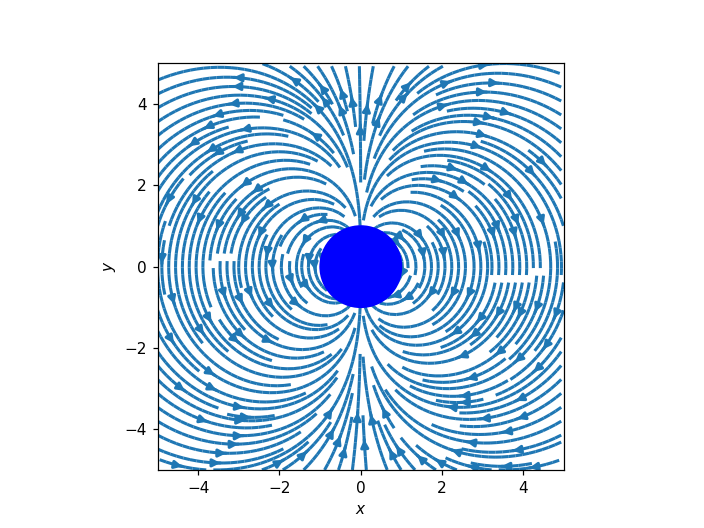

In [6]:
import sys
from matplotlib.patches import Circle

# Mean magnitude of the Earth's magnetic field at the equator in T
B0 = 3.12e-5
# B0 = 1
# Radius of Earth, Mm (10^6 m: mega-metres!)
# RE = 6.370
RE = 1
# Deviation of magnetic pole from axis
# alpha = np.radians(9.6)
alpha = np.radians(0)

def B(r, theta):
    """Return the magnetic field vector at (r, theta)."""
    fac = B0 * (RE / r)**3
    return -2 * fac * np.cos(theta + alpha), -fac * np.sin(theta + alpha)

# Grid of x, y points on a Cartesian grid
nx, ny = 100, 100
XMAX, YMAX = 5, 5
x = np.linspace(-XMAX, XMAX, nx)
y = np.linspace(-YMAX, YMAX, ny)
X, Y = np.meshgrid(x, y)
r, theta = np.hypot(X, Y), np.arctan2(Y, X)

# Magnetic field vector, B = (Ex, Ey), as separate components
Br, Btheta = B(r, theta)
# Transform to Cartesian coordinates: NB make North point up, not to the right.
c, s = np.cos(np.pi/2 + theta), np.sin(np.pi/2 + theta)
Bx = -Btheta * s + Br * c
By = Btheta * c + Br * s

fig, ax = plt.subplots()

# ax.streamplot(x, y, Bx, By, color=color, linewidth=1, cmap=plt.cm.inferno,
#               density=2, arrowstyle='->', arrowsize=1.5)
ax.streamplot(X, Y, Bx, By, linewidth=2, density=2, cmap=plt.cm.gist_rainbow)


# Add a filled circle for the Earth; make sure it's on top of the streamlines.
ax.add_patch(Circle((0,0), RE, color='b', zorder=100))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-XMAX, XMAX)
ax.set_ylim(-YMAX, YMAX)
ax.set_aspect('equal')
plt.show()

In [37]:
def magDip(r, theta):
    B = np.zeros((2,1))

    fac   = B0 * (RE / r)**3
#     Br    = (2*m*np.cos(theta))/r**3
#     Bth   = (m*np.sin(theta))  /r**3 
    B[0]  = -2 * fac * np.cos(theta + alpha) # radial contribution
    B[1]  = -fac * np.sin(theta + alpha)     # polar angle cont.
    return B

In [38]:
def param(q,m,r,theta,i): # i=0=r, i=1=theta
    p = q/m*magDip(r,theta)[i]
    return p

In [39]:
"""Define the lorentz force equation for use in ODE solver.
   R represents our state vector (with associated cartesian positions
   and velocities), returns dR/dt."""
def lorentz(t,R,q,m):
    r, theta, phi    = R[0], R[1], R[2]
    vr, vtheta, vphi = R[3], R[4], R[5]

    return np.array([vr,vtheta,vphi, 
                     param(q,m,r,theta,1)*vr,
                     -vtheta*param(q,m,r,theta,0),
                     vphi*param(q,m,r,theta,0)-vphi*param(q,m,r,theta,1)]) #  cross product of (v spher. x B spher.).

In [40]:
# Let's initialize scipy's integration technique!
solver = ode(lorentz).set_integrator('dopri5') # Implements an explicit runge-kutta order (4).

In [44]:
t0 = 0
x0 = np.array([2, 0, 0])
v0 = np.array([-0.1, 0.1, 0.2])
initial_conditions = np.concatenate((x0, v0))

In [45]:
solver.set_initial_value(initial_conditions, t0).set_f_params(1.0, 1.0) # set q, m, B strength.

positions = []
tf = 100
dt = 0.01

# Iterate through scipy's ode solver --> tf.
while solver.successful() and solver.t < tf:
    solver.integrate(solver.t+dt)
    positions.append(solver.y[:6]) # keep everything (position and velocity?)!

positions = np.array(positions)

In [39]:
# fig,ax = plt.subplots()
# ax.plot(np.arange(0,50,0.1),positions[:, 0][:-1])

<IPython.core.display.Javascript object>


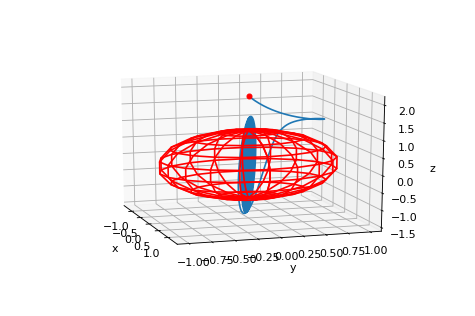

In [46]:
%matplotlib notebook
X = positions[:, 0] * np.sin(positions[:, 2]) * np.cos(positions[:, 1])
Y = positions[:, 0] * np.sin(positions[:, 2]) * np.sin(positions[:, 1])
Z = positions[:, 0] * np.cos(positions[:, 2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.
ax.plot3D(X, Y, Z) # solution x, y, z
ax.scatter3D(X[0],Y[0],Z[0],color='red')

B1 = np.array([x0[0], x0[1], -1])
B2 = np.array([50, 0, 0])
B_axis = np.vstack((B1, B1 + B2))
# ax.plot3D(X, 
#           Y,
#           Z)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r")

### We need to randomize initial conditions in order to have a proper distribution of particles!

## Position distribution generation

In [140]:
N = 5

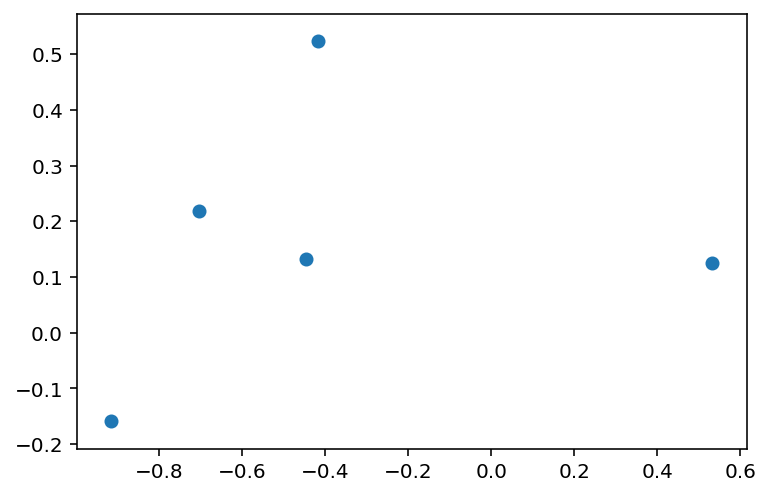

In [141]:
%matplotlib inline
x0 = np.array([2, 0, 0]) # r, theta, phi

randy = (np.random.random(N)*2)-1
randz = (np.random.random(N)*2)-1

xC = np.array([2,randy,randz])
fig = plt.figure()
plt.scatter(xC[1],xC[2])

<IPython.core.display.Javascript object>


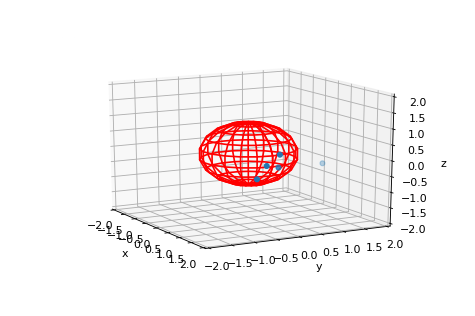

In [142]:
%matplotlib notebook
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r")

ax.scatter(xC[0],xC[1],xC[2])
plt.xlabel('x')
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_zlim(-2,2)
plt.ylabel('y')
ax.set_zlabel('z');

## Velocity distribution generation

### Re-check the justification for this velocity distribution!!!

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1.]),
 array([-0.13082726, -0.12718385, -0.12354044, -0.11989704, -0.11625363,
        -0.11261022, -0.10896681, -0.1053234 , -0.10168   , -0.09803659,
        -0.09439318, -0.09074977, -0.08710636, -0.08346296, -0.07981955,
        -0.07617614, -0.07253273, -0.06888932, -0.06524592, -0.06160251,
        -0.0579591 ]),
 <a list of 20 Patch objects>)

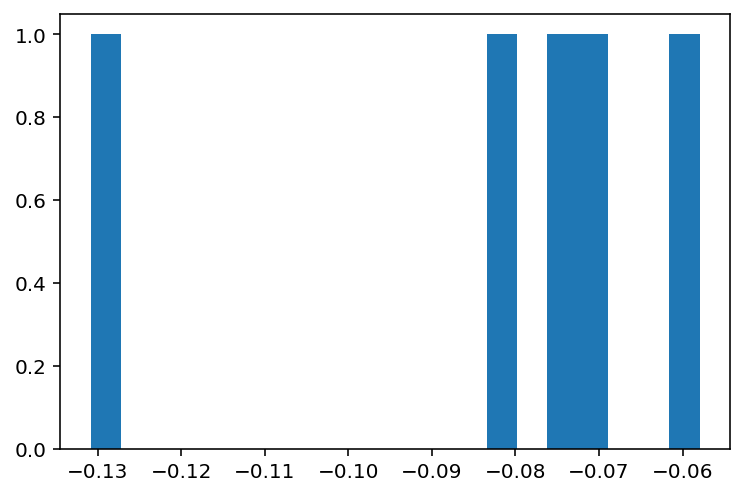

In [143]:
%matplotlib inline

# the center location comes from typical solar wind speed ~500 km/s.
# we know the Earth's radius is 6371 km: if we scale this to 1 unit of distance,
# we find that typical solar wind speeds account for 0.0785 km scales.
# solar wind varies by +- 250 km/s. Same calculation yields an approximate width or scale of 0.04.
randvx = np.random.normal(loc=-0.078480615288,scale=0.039240307644/2,size=N)

vC = np.array([randvx, 0, 0])
fig = plt.figure()
plt.hist(vC[0],bins=20)

## Let's see this at work!

Cartesian to spherical:
$$r=\sqrt{x^2+y^2+z^2}       \\
  \theta = \arctan{(\frac{\sqrt{x^2+y^2}}{z})}\\
  \phi = \arctan{(\frac{y}{x})}$$

In [144]:
def cart_to_sph(arr):
    sph_list = []
    for coord in arr:
        x,y,z = coord[0],coord[1],coord[2]
        r  = np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        th = np.arctan(np.sqrt(pow(x,2)+pow(y,2))/z)
        ph = np.arctan(y/x)
        sph_list.append([r,th,ph])
    return sph_list

Spherical to cartesian:
$$x=r\sin \theta \cos \phi   \\
  y=r\sin \theta \sin \phi   \\
  z=r\cos \theta$$

In [145]:
def sph_to_cart(arr):
    cart_list = []
    for coord in arr:
        r,t,p = coord[0],coord[1],coord[2]
        x = r*np.sin(t)*np.cos(p)
        y = r*np.sin(t)*np.sin(p)
        z = r*np.cos(t)
        cart_list.append([x,y,z])
    return cart_list

In [146]:
"""Cartesian velocity to Spherical velocity!"""
def c_to_s_vel(pos,vel):
    s_vel = []
    for i, c_vel in enumerate(vel):
        xd,yd,zd = c_vel[0],c_vel[1],c_vel[2]
        x,y,z = pos[i][0],pos[i][1],pos[i][2]
        rd = (x*xd+y*yd+z*zd)/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        td = (xd*y-x*yd)/(pow(x,2)+pow(y,2))
        pd = (z*(x*xd+y*yd)-(pow(x,2)+pow(y,2))*zd)/((pow(x,2)+pow(y,2)+pow(z,2))*np.sqrt(pow(x,2)+pow(y,2)))
        s_vel.append([rd,td,pd])
    return s_vel

In [157]:
# Let's initialize scipy's integration technique!
solver = ode(lorentz).set_integrator('dopri5') # Implements an explicit runge-kutta order (4).

t0 = 0
x0 = []
for i,item in enumerate(randy):
    x0.append([2, randy[i], randz[i]])

v0 = []
for item in vC[0]:
    v0.append([item, 0, 0])

x0 = cart_to_sph(x0)
v0 = c_to_s_vel(x0,v0)
print(x0)
print(v0)

[[2.1315246130761496, 1.4684062404704963, -0.33855515849261547], [2.073598770592488, 1.5101899875895681, 0.260424197300411], [2.108983489247623, 1.3199596104738842, -0.2054922409865204], [2.2055005556399423, -1.498705891501786, -0.4294734437174519], [2.0533552726835684, 1.5064946808165276, -0.21937949635852275]]
[[-0.060848896978154175, -0.016333050499834727, 0.0030489390459123916], [-0.06465353814272869, -0.01845001498959599, -0.0025455940263926385], [-0.05864879179426452, -0.014803820769038157, 0.001940350633170836], [-0.04732843252174769, 0.01221650394482903, 0.0028223196808944647], [-0.10509338733012243, -0.03038804024166661, 0.0035416275863356193]]


In [148]:
cart_to_sph(x0)

[[2.610408714846027, -1.4407356466127275, 0.6032370490612875],
 [2.5784310001545556, 1.4696227774966053, 0.6294640696330258],
 [2.4964638576008085, -1.488389765092896, 0.5592281346028667],
 [2.7008886480210146, -1.4111065855920477, -0.5968558494027743],
 [2.556153646127013, -1.4848665510985224, 0.6329707437978134]]

# SOME OF THESE ARE NEGATIVE???? WHY???

In [149]:
sph_to_cart(cart_to_sph(x0))

[[-2.1315246130761496, -1.468406240470496, 0.3385551584926156],
 [2.0735987705924885, 1.5101899875895684, 0.2604241973004109],
 [-2.108983489247623, -1.3199596104738842, 0.20549224098652025],
 [-2.2055005556399423, 1.4987058915017857, 0.42947344371745183],
 [-2.053355272683569, -1.5064946808165278, 0.21937949635852277]]

$$ \dot{\rho}=\frac{X\dot{X}+Y\dot{Y}+Z\dot{Z}}{\sqrt{X^2+Y^2+Z^2}} $$\
$$ \dot{\theta}=\frac{\dot{X}Y-x\dot{Y}}{X^2+Y^2} $$\
$$ \dot{\phi} = \frac{Z(X\dot{X}+Y\dot{Y})-(X^2+Y^2)\dot{Z}}{(X^2+Y^2+Z^2)\sqrt{X^2+Y^2}} $$

[ 2.13152461  1.46840624 -0.33855516 -0.0608489  -0.01633305  0.00304894]
[ 2.07359877  1.51018999  0.2604242  -0.06465354 -0.01845001 -0.00254559]
[ 2.10898349e+00  1.31995961e+00 -2.05492241e-01 -5.86487918e-02
 -1.48038208e-02  1.94035063e-03]
[ 2.20550056 -1.49870589 -0.42947344 -0.04732843  0.0122165   0.00282232]
[ 2.05335527  1.50649468 -0.2193795  -0.10509339 -0.03038804  0.00354163]


C:\Users\ENG\Anaconda3\lib\site-packages\scipy\integrate\_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


<IPython.core.display.Javascript object>


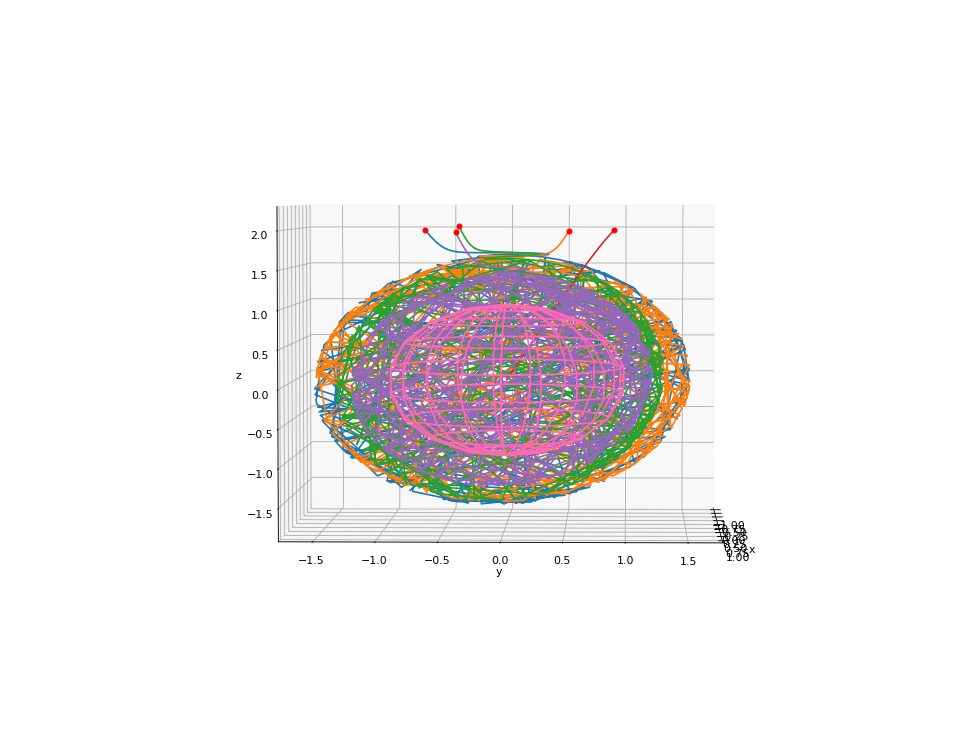

In [156]:
%matplotlib notebook
%matplotlib notebook

posList = []
for index, particle in enumerate(x0):
    initial_conditions = np.concatenate((x0[index], v0[index]))
    print(initial_conditions)
    solver.set_initial_value(initial_conditions, t0).set_f_params(1.0, 1.0) # set q, m, B strength.

    positions = []
    tf = 100
    dt = 0.5

    # Iterate through scipy's ode solver --> tf.
    while solver.successful() and solver.t < tf:
        solver.integrate(solver.t+dt)
        positions.append(solver.y[:6]) # keep everything (position and velocity?)!

    positions = np.array(positions)
    posList.append(positions)
    
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

for positions in posList:
    X = positions[:, 0] * np.sin(positions[:, 2]) * np.cos(positions[:, 1])
    Y = positions[:, 0] * np.sin(positions[:, 2]) * np.sin(positions[:, 1])
    Z = positions[:, 0] * np.cos(positions[:, 2])


    ax.plot3D(X, Y, Z) # solution x, y, z
    ax.scatter3D(X[0],Y[0],Z[0],color='red')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="hotpink")

Coordinate shift, interpolation.
(cylindrical)

Particle motion, energy loss consideration: (1) due to B field as it accelerates (could ignore), (2) energy lost due to collisions with molecules